In [1850]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def f(x):
    return 3*x**2 - 4*x + 5
f(3.0)    

20.0

In [1851]:
xs = np.arange(-5,5,0.25)
print('xs:')
xs


xs:


array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [1852]:
ys = f(xs)
print('ys:')
ys

ys:


array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

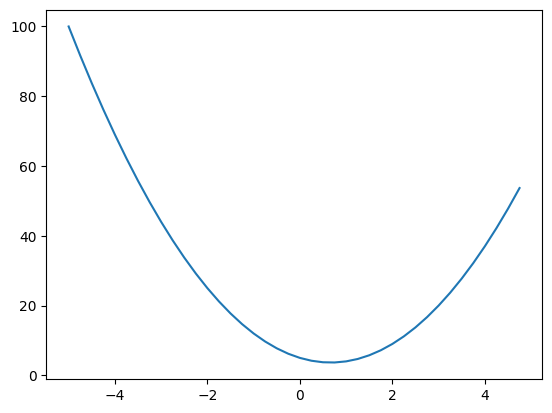

In [1853]:
plt.plot(xs, ys)

Simple derivative (see As a limit):
https://en.wikipedia.org/wiki/Derivative#:~:text=In%20mathematics%2C%20the%20derivative%20is,the%20function%20at%20that%20point.

In [1854]:
h = 0.00001
x = 2/3
(f(x + h) - f(x))/h


3.0000002482211127e-05

In [1855]:
# more complex example
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [1856]:
h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
# derivative of d with respect to a
a += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
print('slope: ', (d2 - d1)/h)

d1:  4.0
d2:  3.999699999999999
slope:  -3.000000000010772


In [1857]:
class Value:
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0 # 0 means no effect
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out    
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        out = self + (-other)
        return out    
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other): # other * self
        return self * other 
    
    def __radd__(self, other): # other + self
        return self + other
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad 
        out._backward = _backward
        
        return out
    
    def exp(self):
        n = self.data
        e = math.exp(n)
        out = Value(e, (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Currently only supporting int/float powers"
        out = Value(self.data ** other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
            # other.grad += self.data**other * math.log(self.data) * out.gradw
        out._backward = _backward
        
        return out
    
      
    def backward(self):
        topologically_ordered_graph_nodes = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topologically_ordered_graph_nodes.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topologically_ordered_graph_nodes):
            node._backward()
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
# L.grad = 1.0
# f.grad = 4.0
# d.grad = -2.0
# c.grad = -2.0
# e.grad = -2.0
# # de/da = -3.0 (value of b)
# # dL/da (a.grad) = (dL/de * de/da)
# a.grad = (-2.0 * -3.0)
# # de/db = 2.0 (value of a)
# # dL/db (a.grad) = (dL/de * de/db)
# b.grad = -2.0 * 2.0
L 

Value(data=-8.0)

In [1858]:
a = Value(2.0, label='a')
b = Value(4.0, label='b')
a - b

Value(data=-2.0)

L = d * f  

dL/dd =? f  

(f(x+h)-f(x))/h  

((d+h)*f - d*f)/h  
(d*f + h*f - d*f) / h  
(h*f)/h  
f  



dd / dc = 1.0  
dd / de = 1.0  
d = c + e  

WANT:  
dL / dc = (dL / dd) * (dd / dc)

KNOW:  
dl / dd  
dd / dc  

In [1859]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = '''<<TABLE BORDER="0" CELLBORDER="0" CELLSPACING="0">
                      <TR><TD><B> %s </B></TD></TR>
                      <TR><TD>data %.4f</TD></TR>
                      <TR><TD>grad %.4f</TD></TR>
                    </TABLE>>''' % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

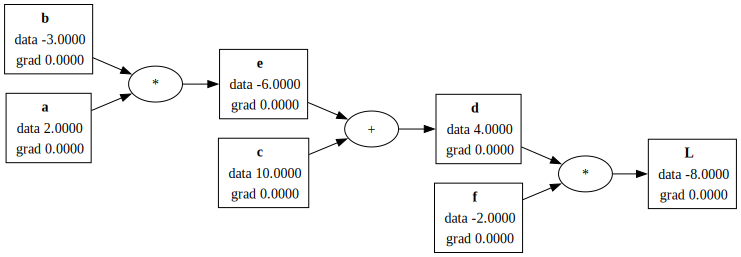

In [1860]:
draw_dot(L)

In [1861]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-36.0


dL / de = -2.0   
e = a * b
de / da? b



dL / da = (dL / de) * (de / da)

In [1862]:
# Just add h to the value (for example, a, b, c, d,e). 
# After calling this function, you will get the derivative for the variable that you added h to
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label
    L1 = L.data
    
    a = Value(2.0, label='a')
    # a.data += h
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    # e.data += h
    d = e + c; d.label = 'd'
    # d.data += h
    # c.data += h
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1)/h)
    
lol()   

-3.9999999999995595


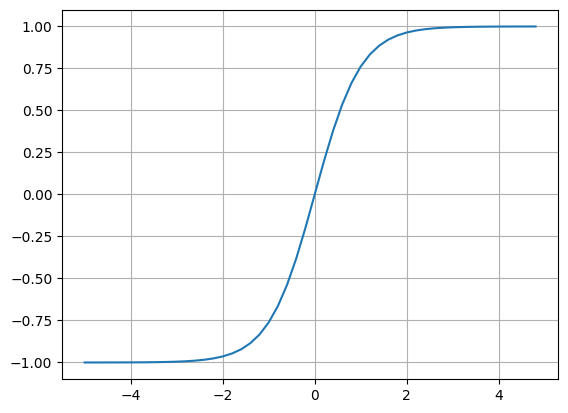

In [1863]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [1864]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
print('n: ', n.data)

# simple tanh
# o = n.tanh(); o.label = 'o'

# more complex tanh
e = (2*n).exp() ; e.label = 'e'
print('e: ', e.data)
o = (e - 1)/(e + 1); o.label = 'o'
print('o: ', o.data)

n:  0.8813735870195432
e:  5.828427124746192
o:  0.7071067811865477


In [1865]:
# Backpropagation for o MANUAL
# o.grad = 1.0
# # derivative for tanh: do/dn = 1 - tanh(n)^2 = 1 - o^2
# print('o.data: ', o.data)
# print('1- o.data^2: ', 1 - o.data**2)
# n.grad = 1 - o.data**2
# b.grad = n.grad
# x1w1x2w2.grad = n.grad
# x1w1.grad = x1w1x2w2.grad
# x2w2.grad = x1w1x2w2.grad
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad
# x1.grad = w1.data * x2w2.grad
# w1.grad = x1.data * x2w2.grad
# !important: derivative (grad) always tells the influence of the variable on the final output

# Backpropagation for o AFTER _Backward implementation in Value (Also MANUAL)
# o.grad = 1.0 # we still need to set the gradient of the output
# o._backward()
# n._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()
# x1._backward()
# w1._backward()
# x2._backward()
# w2._backward()


# Backpropagation automatically
o.backward()  

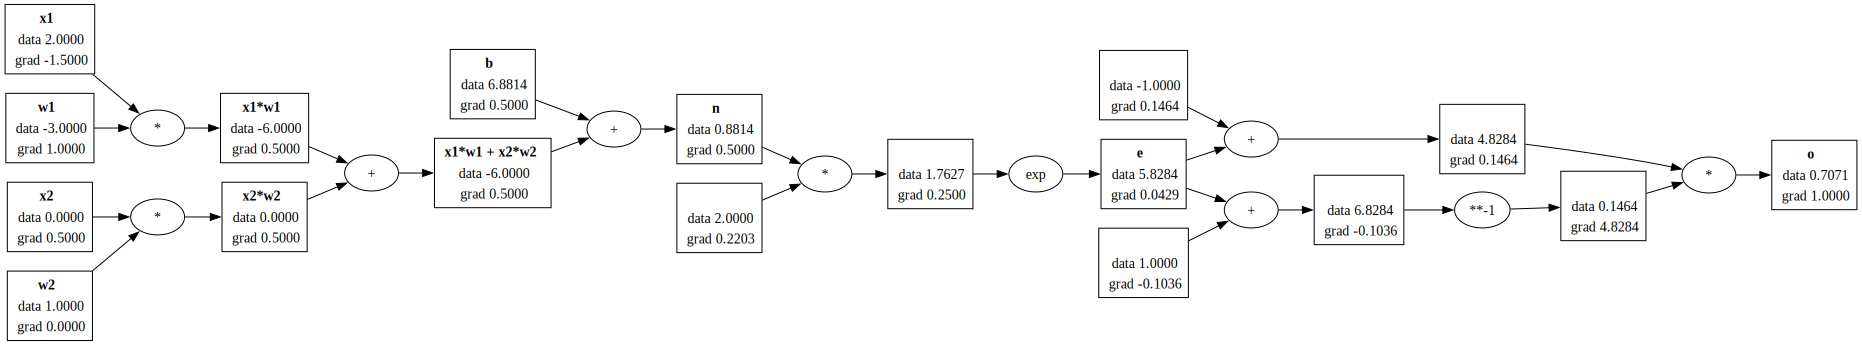

In [1866]:
draw_dot(o)

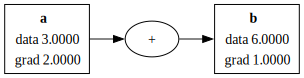

In [1867]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

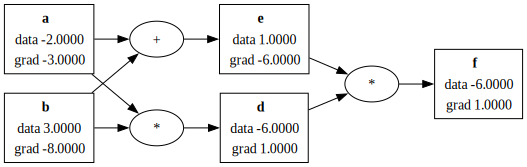

In [1868]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [1869]:
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print('o value: ', o.data.item())
o.backward()

print('--Gradients--')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

o value:  0.7071066904050358
--Gradients--
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


<image src="images/neuron.jpg"/>    
<image src="images/multilayer-perceptron.png" width="600px"/>

In [1870]:
import random

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:
    
    def __init__(self, n_in, nout):
        self.neurons = [Neuron(n_in) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
                       
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.31469016816425927)

In [1871]:
len(n.parameters())

41

In [1872]:
# draw_dot(n(x))

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [1912]:
# ypred = [n(x) for x in xs]
# loss = sum((yout - ygt)**2.0 for ygt, yout in zip(ys, ypred))
# loss

Value(data=2.0438670758041165e-05)

In [1915]:
# loss.backward()

In [1916]:
# gradient descent - vector pointing in the direction of increased loss 
# for p in n.parameters():
#     p.data += -0.1 * p.grad

In [1918]:
# ypred

[Value(data=0.9995175327463487),
 Value(data=-0.9998192463833548),
 Value(data=-0.9955353998383158),
 Value(data=0.9995095210161945)]

In [1919]:
# weights for current ypred
# n.parameters()

[Value(data=1.3984402294609917),
 Value(data=0.7642458134763318),
 Value(data=0.29004906989007984),
 Value(data=1.5311945603009705),
 Value(data=-0.25201016616594374),
 Value(data=-1.8744826356437767),
 Value(data=1.0693513063038083),
 Value(data=-0.329189579278396),
 Value(data=1.3542024559476267),
 Value(data=1.0918323588613932),
 Value(data=0.23298408238209983),
 Value(data=0.838035682242902),
 Value(data=0.0840614401219984),
 Value(data=0.6889049775651688),
 Value(data=-1.6803213788124027),
 Value(data=-0.485170066666595),
 Value(data=-0.3289065610708607),
 Value(data=-0.20930220554516393),
 Value(data=0.8194655890040315),
 Value(data=2.184741085668207),
 Value(data=-0.0855260430937448),
 Value(data=0.8300434014842156),
 Value(data=1.2933980674237202),
 Value(data=-0.20060986128008435),
 Value(data=-4.471603550428342),
 Value(data=0.5425454650749),
 Value(data=0.023502437236716203),
 Value(data=-1.6190270962705426),
 Value(data=0.8418890013432085),
 Value(data=2.1373376355961007),


In [1954]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0 # !important: zero the gradients - very common mistake to forget this
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print('iteration: ', k, "loss: ", loss.data)

iteration:  0 loss:  1.9470433104156158e-05
iteration:  1 loss:  1.9459553812965943e-05
iteration:  2 loss:  1.9448686152366164e-05
iteration:  3 loss:  1.943783010415554e-05
iteration:  4 loss:  1.9426985650169556e-05
iteration:  5 loss:  1.9416152772280915e-05
iteration:  6 loss:  1.940533145240479e-05
iteration:  7 loss:  1.9394521672484007e-05
iteration:  8 loss:  1.938372341451137e-05
iteration:  9 loss:  1.9372936660502188e-05
iteration:  10 loss:  1.9362161392517035e-05
iteration:  11 loss:  1.935139759265653e-05
iteration:  12 loss:  1.934064524304757e-05
iteration:  13 loss:  1.9329904325863035e-05
iteration:  14 loss:  1.931917482330596e-05
iteration:  15 loss:  1.930845671762124e-05
iteration:  16 loss:  1.929774999108588e-05
iteration:  17 loss:  1.928705462601365e-05
iteration:  18 loss:  1.9276370604755248e-05
iteration:  19 loss:  1.9265697909699148e-05


In [1955]:
ypred

[Value(data=0.9998082129128474),
 Value(data=-0.9999435875216806),
 Value(data=-0.995619517467512),
 Value(data=0.9998073707245565)]